# DigiLab 5 - Economic Dispatch 
Author: Emil G. Melfald, University of South-Eastern Norway <br><br>

The Economic Dispatch (ED) problem represents the calculation when minimizing the cost of power generation in the system, given some load and some committed generating units. This is typically done after a Unit Comittment (UC) computation is done. 

This notebook is the second of three that will help you understand UC, ED, and OPF. This second notebook will teach you to define objective functions and simple generation-demand constraints and generation bounds when solving the ED problem. The main difference between UC and ED is that the result of UC is which generating units are online and offline at any time. The result from ED is the active power dispatch from all the online units to meed the demand. 

The objective for DigiLab 5 is to show how we can use Scipy's **minimize** to do ED. We assume that Unit commitment has been done, meaning we know which generating unit is online. We are not coding our own solver/solution algorithm to solve ED, as that will take too much time. We will use PyPSA for PowerFlow simulator. However, we are not going to use the network.optimize() functionality. Instead we are making the objective function and constraints ourselves.  Hence, the objective of ED is: 

$$ \vec{P_g^{opt}} = \arg\min_{\vec{P_i}} \sum_{P_i \in \vec P_g} C_i (P_i) $$

Subject to the constraint that the generator supplies the demand and power losses

$$ \sum_{P_i \in \vec{P_g}} P_i = D + P_{loss} $$

and that all units active power production is bounded 

$$ P_i^{min} \le P_i \le P_i^{max} $$

**Note**: PyPSA documentation and explanations for keywords when defining grid components is found [here](https://pypsa.readthedocs.io/en/latest/components.html).

## Prerequisites 
You must have completed **Assignment 1** in the EPE2316 course. That also includes Digilab 1 to 3. Familiarity with Digilab 4 is adviced. 

## Learning Objectives 
By the end of this notebook you should be able to: 
- Formulate linear and quadratic cost functions for ED
- Define bounds and constraints for ED in the scipy framework
- Solve the ED problem with scipy.minimize 

## Contents 
1. [Visualizing linear cost functions](#LinearCostVis)
2. [Defining and solving linear ED](#LinearED)
3. [Visualizing quadratic cost functions](#QuadraticCostVis) 
4. [Defining and solving quadratic ED](#QuadraticED) 
5. [Including power losses in the constraints](#PowerLosses) 

In [1]:
import pypsa 
import numpy as np 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import sys
import os
from copy import copy 

c:\Users\emelf\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# [Visualizing linear cost functions](#LinearCostVis)
![Image of the power system under study](Power_System_Drawing.png)
Assume the power system depicted in the figure. We have two generating units connected through some transmission lines, and to a large power system at Bus 2. 

In [2]:
C1 = lambda P: 10*P # Cost of operating generator 1
C2 = lambda P: 20*P # Cost of operating generator 2
C_tot = lambda P1, P2: C1(P1) + C2(P2) # Total cost of operation (without losses) 

N_g1 = 11
N_g2 = 11
P_g1_vals = np.linspace(0, 6, N_g1)
P_g2_vals = np.linspace(0, 6, N_g2) 

cost_tot_vals = np.zeros((N_g2, N_g1), dtype=float)

for j, P1 in enumerate(P_g1_vals): 
    for i, P2 in enumerate(P_g2_vals): 
        cost = C_tot(P1, P2)
        cost_tot_vals[i, j] = cost 

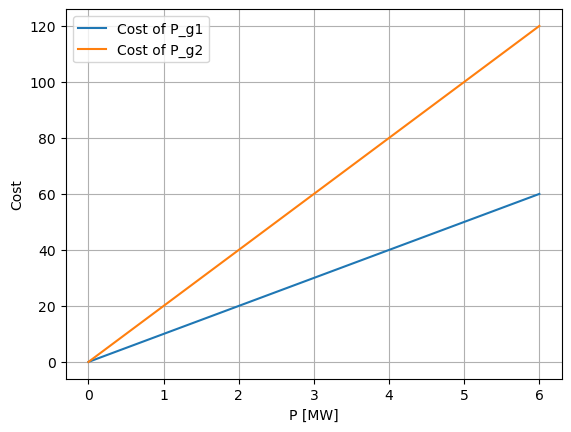

In [3]:
plt.plot(P_g1_vals, C1(P_g1_vals), label="Cost of P_g1")
plt.plot(P_g2_vals, C2(P_g2_vals), label="Cost of P_g2")

plt.xlabel("P [MW]")
plt.ylabel("Cost")
plt.grid()
plt.legend()
plt.show()

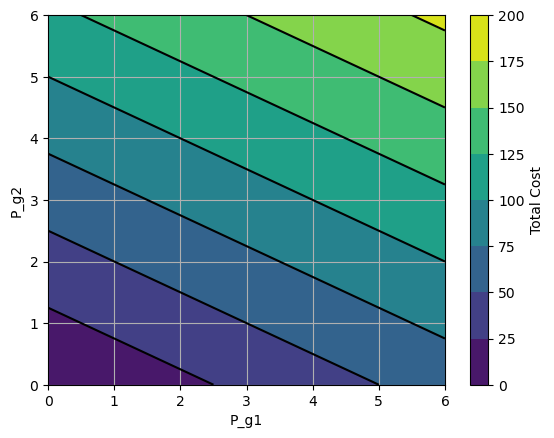

In [4]:
P_g1_mesh, P_g2_mesh = np.meshgrid(P_g1_vals, P_g2_vals)

plt.contour(P_g1_mesh, P_g2_mesh, cost_tot_vals, colors="black")
cp = plt.contourf(P_g1_mesh, P_g2_mesh, cost_tot_vals)
plt.colorbar(cp, label="Total Cost")
plt.xlabel("P_g1")
plt.ylabel("P_g2")
plt.grid()

plt.show() 

# [Defining and solving linear ED](#LinearED)

Assume the dispatched power is 10 MW. We ignore power losses for now. 

In [5]:
def objective(X): # Want to minimize the total cost of generation from G1 and G2
    P1, P2 = X 
    return C_tot(P1, P2) 

# Each generator have to have a power output between 0 and 6 MW. 
bounds = [(0, 6), (0, 6)] 

# This tells Scipy that the total dispatched power P_g1 + P_g2 should be equal to P_tot
cons = ({'type': 'eq', 'fun': lambda x, P_tot=10:  x[0] + x[1] - P_tot})
res = minimize(objective, 
               x0=np.array([5.0, 5.0]), # Could use another initial condition. Try for yourself.  
               bounds=bounds, 
               constraints=cons) 
P_g1_opt, P_g2_opt = res.x 

print(f"Optimal values: P_g1 = {P_g1_opt}, P_g2 = {P_g2_opt}")
print(f"Total cost of operation: {res.fun}")

Optimal values: P_g1 = 6.0, P_g2 = 3.9999999999999756
Total cost of operation: 139.99999999999952


In [6]:
# Visualizing the optimal active power dispatch: 
P_tot_opt = np.linspace(0.0, 12.0, 40)
P1_opt_vals = []
P2_opt_vals = []
for P_tot in P_tot_opt: 
    cons = ({'type': 'eq', 'fun': lambda x, P_tot=P_tot:  x[0] + x[1] - P_tot})
    res = minimize(objective, x0=np.array([5.0, 5.0]), bounds=bounds, constraints=cons) 
    P1_opt_vals.append(res.x[0])
    P2_opt_vals.append(res.x[1])


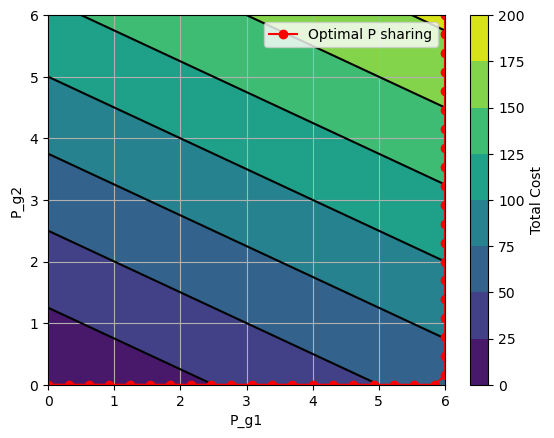

In [7]:
P_g1_mesh, P_g2_mesh = np.meshgrid(P_g1_vals, P_g2_vals)

plt.contour(P_g1_mesh, P_g2_mesh, cost_tot_vals, colors="black")
cp = plt.contourf(P_g1_mesh, P_g2_mesh, cost_tot_vals)
plt.colorbar(cp, label="Total Cost")

plt.plot(P1_opt_vals, P2_opt_vals, 'o-', label="Optimal P sharing", color="red")

plt.xlabel("P_g1")
plt.ylabel("P_g2")
plt.grid()
plt.legend()
plt.show() 

# [Visualizing quadratic cost functions](#QuadraticCostVis) 

In [8]:
N_g1 = 11
N_g2 = 11 
P_g1_vals = np.linspace(0, 6, N_g1)
P_g2_vals = np.linspace(0, 6, N_g2)

C1 = lambda P: 3*P + 3*P**2
C2 = lambda P: 6*P + 2*P**2
C_tot = lambda P1, P2: C1(P1) + C2(P2)

cost_tot_vals = np.zeros((N_g2, N_g1), dtype=float)

for j, P1 in enumerate(P_g1_vals): 
    for i, P2 in enumerate(P_g2_vals): 
        cost = C_tot(P1, P2)
        cost_tot_vals[i, j] = cost 

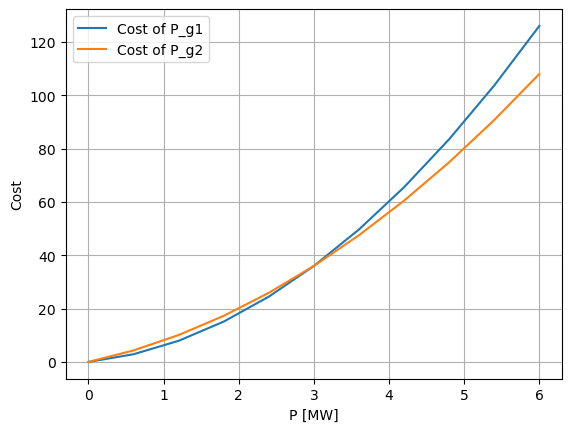

In [9]:
plt.plot(P_g1_vals, C1(P_g1_vals), label="Cost of P_g1")
plt.plot(P_g2_vals, C2(P_g2_vals), label="Cost of P_g2")

plt.xlabel("P [MW]")
plt.ylabel("Cost")
plt.grid()
plt.legend()
plt.show()

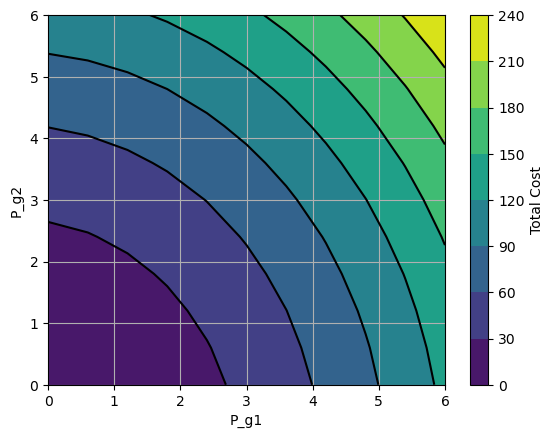

In [10]:
P_g1_mesh, P_g2_mesh = np.meshgrid(P_g1_vals, P_g2_vals)

plt.contour(P_g1_mesh, P_g2_mesh, cost_tot_vals, colors="black")
cp = plt.contourf(P_g1_mesh, P_g2_mesh, cost_tot_vals)
plt.colorbar(cp, label="Total Cost")
plt.xlabel("P_g1")
plt.ylabel("P_g2")
plt.grid()

plt.show() 

# [Defining and solving quadratic ED](#QuadraticED) 

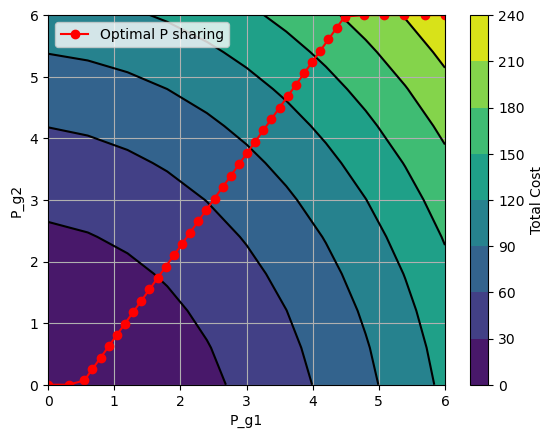

In [11]:
# Visualizing the optimal active power dispatch: 
P_tot_opt = np.linspace(0.0, 12.0, 40)
P1_opt_vals = []
P2_opt_vals = []
for P_tot in P_tot_opt: 
    cons = ({'type': 'eq', 'fun': lambda x, P_tot=P_tot:  x[0] + x[1] - P_tot})
    res = minimize(objective, x0=np.array([5.0, 5.0]), bounds=bounds, constraints=cons) 
    P1_opt_vals.append(res.x[0])
    P2_opt_vals.append(res.x[1])
    
P_g1_mesh, P_g2_mesh = np.meshgrid(P_g1_vals, P_g2_vals)

plt.contour(P_g1_mesh, P_g2_mesh, cost_tot_vals, colors="black")
cp = plt.contourf(P_g1_mesh, P_g2_mesh, cost_tot_vals)
plt.colorbar(cp, label="Total Cost")

plt.plot(P1_opt_vals, P2_opt_vals, 'o-', label="Optimal P sharing", color="red")

plt.xlabel("P_g1")
plt.ylabel("P_g2")
plt.grid()
plt.legend()
plt.show() 

# [Including power losses in the constraints](#PowerLosses) 
This causes the optimization to be noticably more complicated. We need to solve the power flow equations (using PyPSA) to estimate power losses. 

In [12]:
def create_network(): 
    V_base = 22 
    network = pypsa.Network() 
    network.add("Bus", "Bus 1", v_nom=V_base)
    network.add("Bus", "Bus 2", v_nom=V_base)
    network.add("Bus", "Bus 3", v_nom=V_base)
    network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
    network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
    network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

    network.add("Generator", "Hydro 1", bus="Bus 1", control="PV", p_set=0.0)
    network.add("Generator", "Hydro 2", bus="Bus 3", control="PV", p_set=0.0)
    network.add("Generator", "Slack", bus="Bus 2", control="Slack")
    return network 
    
def get_P_out_and_loss(P_g1, P_g2, network):
    change_P_gens(network, P_g1, P_g2)
    network.pf() 
    P_out = get_P_out(network) 
    P_loss = P_g1 + P_g2 - P_out 
    return P_out, P_loss 

def change_P_gens(network, P1, P2):
    network.generators.p_set.at["Hydro 1"] = P1
    network.generators.p_set.at["Hydro 2"] = P2 
    
def get_P_out(network): # Obtains the active power going into the external grid. 
    return -network.generators_t.p["Slack"]["now"]    

In [13]:
# Initially define a net 
net = create_network() 

# WARNING: The following constrain is very inefficient. 
def constraint_1(x, P_out_set=10):
    P_g1, P_g2 = x 
    network = copy(net) # do the copy operation to not modify the original net object. 
    P_out_calc, P_loss = get_P_out_and_loss(P_g1, P_g2, network)
    P_gen = P_g1 + P_g2 
    P_dem = P_loss + P_out_set 
    return P_gen - P_dem 

bounds = [(0, 6), (0, 6)]
cons = ({'type': 'eq', 'fun': lambda x: constraint_1(x)})

res = minimize(objective, x0=np.array([5.0, 5.0]), bounds=bounds, constraints=cons) 
P_g1_opt, P_g2_opt = res.x
print(f"Optimal values: P_g1 = {P_g1_opt}, P_g2 = {P_g2_opt}, sum of generation = {P_g1_opt + P_g2_opt}")
print(f"Total cost of operation: {res.fun}")

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020043 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.022195 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020137 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020212 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network 

Optimal values: P_g1 = 4.305323072422409, P_g2 = 5.89058222624648, sum of generation = 10.19590529866889
Total cost of operation: 173.2648007768862


### **Warning: The following cell takes a while to complete (around 5 minutes)**

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')


INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.015520 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.021963 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020071 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020158 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error o

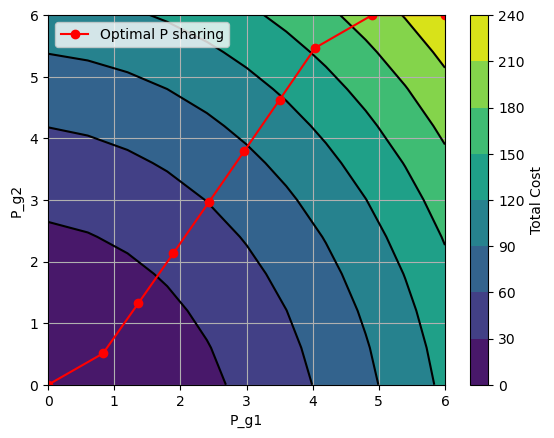

In [15]:
# Visualizing the optimal active power dispatch: 
P_tot_opt = np.linspace(0.0, 12.0, 10)
P1_opt_vals = []
P2_opt_vals = []
for P_tot in P_tot_opt: 
    cons = ({'type': 'eq', 'fun': lambda x: constraint_1(x, P_out_set=P_tot)})
    res = minimize(objective, x0=np.array([5.0, 5.0]), bounds=bounds, constraints=cons) 
    P1_opt_vals.append(res.x[0])
    P2_opt_vals.append(res.x[1])
    
P_g1_mesh, P_g2_mesh = np.meshgrid(P_g1_vals, P_g2_vals)

plt.contour(P_g1_mesh, P_g2_mesh, cost_tot_vals, colors="black")
cp = plt.contourf(P_g1_mesh, P_g2_mesh, cost_tot_vals)
plt.colorbar(cp, label="Total Cost")

plt.plot(P1_opt_vals, P2_opt_vals, 'o-', label="Optimal P sharing", color="red")

plt.xlabel("P_g1")
plt.ylabel("P_g2")
plt.grid()
plt.legend()
plt.show() 


#### End of Notebook
---